In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json
from pprint import pprint

In [3]:
import json

In [4]:
import re

In [5]:
import numpy as np

In [6]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [9]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [10]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [11]:
keys += [
    'Outer step',
    'Batch'
]

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [13]:
timestamps = [
    '20211102-1454', # reptile/sage/sgd 
    '20211103-0958', # Reptile/GATConv
    '20211103-1533', # joint, old version, weighted loss, finished
    '20211104-1003', # joint, new version
    '20211104-2219', # reptile/SAGEConv/adam outer lr=.0001. before-after, stopped
    
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [14]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

In [15]:
if True:
    for tmstp in timestamps:
        file = f'logs/train_earl_{tmstp}.log'
        matches = readers[file].grab()
        print(tmstp)
        for task in tasks:
            validation_losses = matches[f'validation prediction loss {task}']
            print(task, ' '.join([f'{loss:.3f}' for loss in validation_losses[-5:]]))
        print('----')

20211102-1454
('atac_region', 'gene') 0.232 0.278 0.327 0.403 0.349
('gene', 'atac_region') 0.048 0.070 0.068 0.076 0.064
('gene', 'protein_name') 0.378 0.362 0.416 0.389 0.335
('protein_name', 'gene') 0.362 0.305 0.319 0.345 0.238
----
20211103-0958
('atac_region', 'gene') 0.345 0.403 0.289 0.367 0.330
('gene', 'atac_region') 0.076 0.098 0.044 0.070 0.076
('gene', 'protein_name') 0.285 0.441 0.304 0.463 0.268
('protein_name', 'gene') 0.271 0.244 0.257 0.262 0.274
----
20211103-1533
('atac_region', 'gene') 56.241 41.394 74.314 59.364 64.108
('gene', 'atac_region') 60.490 59.214 61.667 58.556 57.705
('gene', 'protein_name') 32.498 29.634 28.297 31.434 27.463
('protein_name', 'gene') 39.407 42.322 74.707 44.483 63.669
----
20211104-1003
('atac_region', 'gene') 0.300 0.320 0.321 0.359 0.317
('gene', 'atac_region') 0.177 0.171 0.168 0.170 0.184
('gene', 'protein_name') 0.174 0.182 0.188 0.196 0.190
('protein_name', 'gene') 0.203 0.251 0.226 0.230 0.225
----
20211104-2219
('atac_region', 'g

## Select File

In [45]:
idx = 1

## Get matching log lines

In [46]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [47]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'checkpoint': 40,
 'device': 'cuda:1',
 'gene_ones_weight': 1,
 'inner_lr': 0.01,
 'inner_steps': 5,
 'layers': [['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}],
            ['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}],
            ['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}],
            ['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}]],
 'mode': 'reptile',
 'n_steps': 10000,
 'out_mlp': {'bias': True,
             'dim_in': 32,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 3},
 'outer_lr': 0.1,
 'target_heads': False,
 'train_batch_size': 10,
 'validation_batch_size': 10}


## Current Step

In [48]:
if len(matches['Outer step'])>0:
    batch = matches['Outer step'][-1]
    print(batch)
elif len(matches['Batch'])>0:
    epoch = matches['Batch'][-1]
    print(epoch)

9999.0


## Training loss

('atac_region', 'gene') 0.3243
('gene', 'atac_region') 0.0904
('gene', 'protein_name') 0.4077
('protein_name', 'gene') 0.2939


<Figure size 1080x720 with 0 Axes>

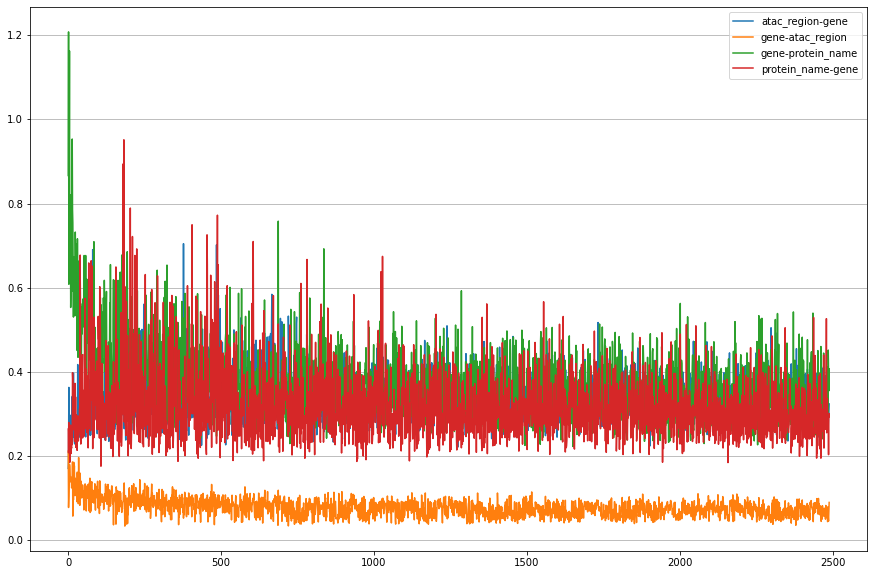

In [49]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[10:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.3242785096168518
('gene', 'atac_region') 0.09036019071936607
('gene', 'protein_name') 0.4076500669121742
('protein_name', 'gene') 0.2939364731311798


<Figure size 1080x720 with 0 Axes>

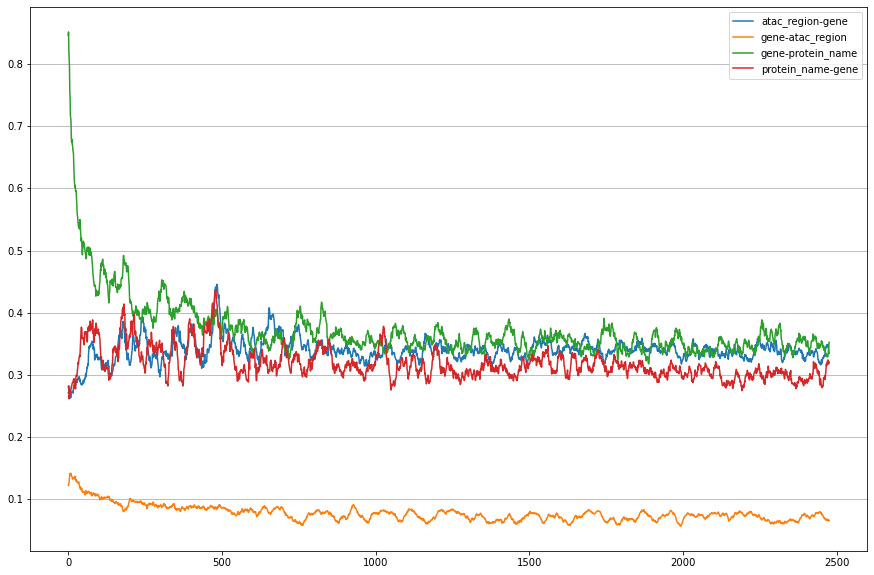

In [50]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],20), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.3300650805234909
('gene', 'atac_region') 0.07645558565855026
('gene', 'protein_name') 0.26812676787376405
('protein_name', 'gene') 0.27442646920681


<Figure size 1080x720 with 0 Axes>

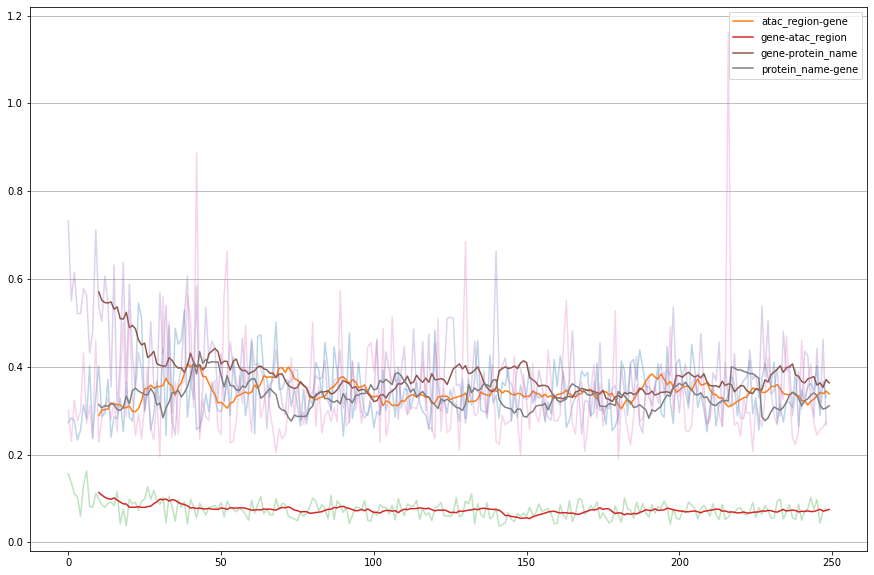

In [51]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

bucket=10

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(validation_loss[1:], 
              alpha=.3)
    _=ax.plot(np.arange(bucket, len(validation_loss)),
              moving_average(validation_loss[1:],bucket), 
              label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
    _=ax.legend()

## Sample predictions

In [52]:
import time

In [53]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

for line in prediction_file:
    print(line.strip(), flush=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Task: ('protein_name', 'gene')
--------------------------------------------------------------------------------
batch 9999 0      pred,y:   0.983 0.000
batch 9999 1      pred,y:   0.975 0.000
batch 9999 2      pred,y:   0.000 0.000
batch 9999 3      pred,y:   0.000 0.000
batch 9999 4      pred,y:   0.000 0.000
batch 9999 5      pred,y:   0.000 0.000
batch 9999 6      pred,y:   0.000 0.000
batch 9999 7      pred,y:   0.000 0.000
batch 9999 8      pred,y:   0.989 0.000
batch 9999 9      pred,y:   0.000 0.000
batch 9999 10     pred,y:   0.000 0.000
batch 9999 11     pred,y:   1.059 0.903
batch 9999 12     pred,y:   0.000 0.000
batch 9999 13     pred,y:   0.000 0.000
batch 9999 14     pred,y:   0.986 0.000
batch 9999 15     pred,y:   0.000 0.000
batch 9999 16     pred,y:   0.000 0.000
batch 9999 17     pred,y:   0.000 0.000
batch 9999 18     pred,y:   0.000 0.000
batch 9999 19     pred,y:   0.000 0.000
batch 9999 20     pred,y:   0.982 0.903
batch 9999 21     pred,y:   0.000 0.000
batch 99

batch 9999 203    pred,y:   0.000 0.000
batch 9999 204    pred,y:   0.000 0.903
batch 9999 205    pred,y:   0.000 0.000
batch 9999 206    pred,y:   0.000 0.000
batch 9999 207    pred,y:   0.000 0.000
batch 9999 208    pred,y:   0.000 0.000
batch 9999 209    pred,y:   0.000 0.000
batch 9999 210    pred,y:   0.000 0.000
batch 9999 211    pred,y:   0.000 0.000
batch 9999 212    pred,y:   1.073 0.000
batch 9999 213    pred,y:   0.000 0.000
batch 9999 214    pred,y:   0.000 0.000
batch 9999 215    pred,y:   0.965 0.000
batch 9999 216    pred,y:   0.975 0.000
batch 9999 217    pred,y:   0.000 0.000
batch 9999 218    pred,y:   0.000 0.000
batch 9999 219    pred,y:   0.000 0.000
batch 9999 220    pred,y:   0.000 0.000
batch 9999 221    pred,y:   0.000 0.000
batch 9999 222    pred,y:   0.000 0.903
batch 9999 223    pred,y:   0.000 1.370
batch 9999 224    pred,y:   0.000 0.000
batch 9999 225    pred,y:   1.036 0.000
batch 9999 226    pred,y:   0.000 0.000
batch 9999 227    pred,y:   0.000 0.000


batch 9999 103    pred,y:   0.000 0.492
batch 9999 104    pred,y:   1.183 2.244
batch 9999 105    pred,y:   0.841 0.952
batch 9999 106    pred,y:   0.000 0.148
batch 9999 107    pred,y:   0.651 0.148
batch 9999 108    pred,y:   0.690 0.670
batch 9999 109    pred,y:   0.698 0.492
batch 9999 110    pred,y:   0.428 1.468
batch 9999 111    pred,y:   0.754 0.148
batch 9999 112    pred,y:   0.708 0.390
batch 9999 113    pred,y:   1.377 1.012
batch 9999 114    pred,y:   1.109 1.504
batch 9999 115    pred,y:   1.035 1.266
batch 9999 116    pred,y:   0.871 1.121
batch 9999 117    pred,y:   1.084 2.174
batch 9999 118    pred,y:   0.553 0.148
batch 9999 119    pred,y:   0.000 0.000
batch 9999 120    pred,y:   0.000 0.585
batch 9999 121    pred,y:   0.951 1.012
batch 9999 122    pred,y:   0.000 0.492
batch 9999 123    pred,y:   0.000 0.748
batch 9999 124    pred,y:   0.493 0.276
batch 9999 125    pred,y:   0.000 0.000
batch 9999 126    pred,y:   0.000 0.585
batch 9999 127    pred,y:   0.859 0.670


batch 9999 170    pred,y:   0.000 0.000
batch 9999 171    pred,y:   0.000 0.000
batch 9999 172    pred,y:   0.000 0.000
batch 9999 173    pred,y:   1.323 0.000
batch 9999 174    pred,y:   1.130 0.000
batch 9999 175    pred,y:   1.668 1.933
batch 9999 176    pred,y:   0.000 0.000
batch 9999 177    pred,y:   0.000 0.000
batch 9999 178    pred,y:   0.000 0.000
batch 9999 179    pred,y:   0.000 0.000
batch 9999 180    pred,y:   0.000 0.000
batch 9999 181    pred,y:   0.000 0.000
batch 9999 182    pred,y:   0.000 0.000
batch 9999 183    pred,y:   0.000 0.000
batch 9999 184    pred,y:   0.000 0.000
batch 9999 185    pred,y:   1.079 0.000
batch 9999 186    pred,y:   0.000 0.000
batch 9999 187    pred,y:   0.000 0.000
batch 9999 188    pred,y:   0.000 0.000
batch 9999 189    pred,y:   0.000 0.000
batch 9999 190    pred,y:   0.000 0.000
batch 9999 191    pred,y:   0.000 0.000
batch 9999 192    pred,y:   0.000 0.000
batch 9999 193    pred,y:   0.000 0.000
batch 9999 194    pred,y:   0.000 0.000


batch 9999 71     pred,y:   0.051 0.000
batch 9999 72     pred,y:   0.030 0.000
batch 9999 73     pred,y:   0.021 0.000
batch 9999 74     pred,y:   0.021 0.000
batch 9999 75     pred,y:   0.054 0.000
batch 9999 76     pred,y:   0.076 0.000
batch 9999 77     pred,y:   0.162 0.000
batch 9999 78     pred,y:   0.087 0.000
batch 9999 79     pred,y:   0.022 0.000
batch 9999 80     pred,y:   0.042 0.000
batch 9999 81     pred,y:   0.021 0.000
batch 9999 82     pred,y:   0.021 0.000
batch 9999 83     pred,y:   0.037 0.000
batch 9999 84     pred,y:   0.021 0.000
batch 9999 85     pred,y:   0.251 0.000
batch 9999 86     pred,y:   0.021 0.000
batch 9999 87     pred,y:   0.054 0.000
batch 9999 88     pred,y:   0.044 0.000
batch 9999 89     pred,y:   0.027 0.000
batch 9999 90     pred,y:   0.035 0.000
batch 9999 91     pred,y:   0.021 0.000
batch 9999 92     pred,y:   0.056 0.000
batch 9999 93     pred,y:   0.042 0.000
batch 9999 94     pred,y:   0.021 0.000
batch 9999 95     pred,y:   0.048 0.000


batch 9999 276    pred,y:   0.033 0.000
batch 9999 277    pred,y:   0.043 0.000
batch 9999 278    pred,y:   0.046 0.000
batch 9999 279    pred,y:   0.056 0.000
batch 9999 280    pred,y:   0.028 0.000
batch 9999 281    pred,y:   0.021 0.000
batch 9999 282    pred,y:   0.023 0.000
batch 9999 283    pred,y:   0.352 0.000
batch 9999 284    pred,y:   0.043 0.000
batch 9999 285    pred,y:   0.056 0.000
batch 9999 286    pred,y:   0.021 0.000
batch 9999 287    pred,y:   0.031 0.000
batch 9999 288    pred,y:   0.047 0.000
batch 9999 289    pred,y:   0.036 0.000
batch 9999 290    pred,y:   0.081 0.000
batch 9999 291    pred,y:   0.028 0.000
batch 9999 292    pred,y:   0.029 0.000
batch 9999 293    pred,y:   0.041 0.000
batch 9999 294    pred,y:   0.041 0.000
batch 9999 295    pred,y:   0.048 0.000
batch 9999 296    pred,y:   0.022 0.000
batch 9999 297    pred,y:   0.028 0.000
batch 9999 298    pred,y:   0.023 0.000
batch 9999 299    pred,y:   0.023 0.000
